In [1]:
import sys
sys.path.insert(1, '/Users/mac/Desktop/PycharmProjects/TAADL/src')
sys.path.insert(2, '/Users/mac/Desktop/PycharmProjects/TAADL/models')

In [2]:
from utils import train_test_split2, generate_portfolio_inputs
from network import MLP, PortfolioLayer
from config import DATA_PATH, PARAM_PATH
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from optuna import trial

# Data Preprocessing

In [3]:
# import data and trained network parameters
features = pd.read_csv(DATA_PATH+'/features.csv', index_col='Date')
prices   = pd.read_csv(DATA_PATH+'/prices.csv', index_col='Date')
prices.index = pd.to_datetime(prices.index)
features.index = pd.to_datetime(features.index)

X, y = train_test_split2(features, test=False)

In [4]:
data1 = generate_portfolio_inputs(X,y) 
data2 = generate_portfolio_inputs(X,y) 
data3 = generate_portfolio_inputs(X,y) 
data4 = generate_portfolio_inputs(X,y) 
data5 = generate_portfolio_inputs(X,y) 

In [5]:
prices = prices.loc[data1.index]

In [6]:
from scipy.optimize import minimize, Bounds, LinearConstraint


class RiskParity:
    def __init__(self, data:pd.DataFrame, bound:list = [0, np.inf]):
        self.data = {}
        self.data["price"] = data
        self.data["lret"]  = np.log(data/data.shift(1)).fillna(0)
        self.data["rv"]    = self.data["lret"].add(1)
        self.num_assets = self.data["price"].shape[1]

        # portoflio weight and performance dataframes which are to be filled.
        self.allocation   = pd.DataFrame(index=self.data["price"].index, columns=self.data["price"].columns)
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['cumulative_return']) # cumulative return
        
        # Optimization constraints
        self.bounds = Bounds([bound[0]]*self.num_assets, [bound[1]]*self.num_assets)  # 모든 weight 의 lower limit 부여. Default: 0 <= x
        self.constraint = LinearConstraint([[1]*self.num_assets], [1], [1])  # 모든 weight 의 합은 1 이라는 조건 부여
  
    def obj_func(self, w: np.ndarray, cov: np.ndarray):
        sigma = np.sqrt(w.T @ cov @ w)
        rc = (cov @ w) * w/sigma
        rc = rc.reshape(-1,1)
        func =  rc - rc.T
        return np.sum(np.ravel(func) ** 2) * 100 # relative risk contribution is equal to 1/N
        
    def calc_weight(self, cov: np.ndarray) -> np.array:
        # define initial weight to optimize
        init_w = np.array([1/self.num_assets] * self.num_assets)
        result = minimize(fun=self.obj_func, method='SLSQP', x0=init_w, args=(cov), bounds=self.bounds, constraints=self.constraint, options ={'ftol':1e-8}) # minimize port. variance
        return result['x'] #normalize the weight

    def run(self):
        # calculate portfolio weight first.
        lret = self.data['lret']
        rv   = self.data['rv'] 
        months = pd.unique(lret.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        for idx in range(1,len(months)):
            last_month = months[idx-1] 
            this_month = months[idx]

            # using the daily return data of the last month, update weight this month
            cov = lret.loc[last_month,:].cov().values
            weight = self.calc_weight(cov)
            self.allocation.loc[this_month,:] = weight.T
        
    def performance(self):
        self.equity_curve = pd.DataFrame(index=self.data["price"].index, columns=['cumulative_return']) # cumulative return
        rv = self.data['rv'] 
        months = pd.unique(rv.index.strftime('%Y-%m')) # a list containing values as 'yyyy-mm' format e.g '2019-01'
        
        aum = 1 # for each month, we calculate daily return
        for idx in range(1,len(months)): 
            this_month = months[idx]
            self.equity_curve.loc[this_month,:] = (rv.loc[this_month,:].cumprod(axis = 0) @ self.allocation.loc[this_month,:].iloc[-1:].T).values * aum
            aum = self.equity_curve.loc[this_month,:].iloc[-1].values # update aum as the latest value of this month.

        df_profit_history = self.equity_curve
        df_profit_history = (df_profit_history / (df_profit_history.shift().fillna(1)))-1
        df_mean = df_profit_history.rolling(252).mean() * 252
        df_std = df_profit_history.rolling(252).std() * np.sqrt(252)
        self.annual_sharpe = (df_mean)/(df_std)


def tactical_allocation(allocation:pd.DataFrame, features:pd.DataFrame, threshold:float=0.025, error_adjust:bool=True) -> pd.DataFrame: 
    assert allocation.shape[0] == features.shape[0], 'allocation and features table length are not equal.'
    exp_return  = features.iloc[:,:7] 
    uncertainty = features.iloc[:,7:14]
    em_mae = features.iloc[:,14:]
    
    # get boolean tables indicating whether asset belongs to high conviction or lower conviction bucket.
    isHigh = (uncertainty < threshold)
    isLow  = (uncertainty > threshold)

    # Calculate overweight factor for high conviction assets.
    F =  isHigh.values * (1 + np.tanh(exp_return/uncertainty.values) ** 2)

    # calculation High conviction (HW) weights
    hw_weight = allocation * F.values
    hw_total  = hw_weight.sum(axis=1).where(hw_weight.sum(axis=1) > 1,1)
    
    if error_adjust:
        error_correction = pd.DataFrame(exp_return/uncertainty.values)/em_mae.values
        error_correction = error_correction * (exp_return > 0).values * (em_mae < 0.03).values * 1 # drop values which prediction error exceeds 5%
        error_correction.columns = allocation.columns
        hw_weight =  error_correction * hw_total.values.reshape((-1,1))
        hw_total  = hw_weight.sum(axis=1).where(hw_weight.sum(axis=1) > 1,1)
    hw_weight = hw_weight/hw_total.values.reshape(-1,1)
    
    # calculation Low conviction (LW) weights
    lw_weight = allocation * (isLow * 1).values
    lw_total  = lw_weight.sum(axis=1).where(lw_weight.sum(axis=1) > 0.0,1)
    lw_weight = lw_weight/lw_total.values.reshape(-1,1)
    lw_total  = 1 - hw_weight.sum(axis=1) # Low conviction total is just 1 minus hw total.
    lw_weight = lw_weight * lw_total.values.reshape(-1,1)

    ta_weight = hw_weight + lw_weight
    return ta_weight

In [37]:
rp = RiskParity(prices)
rp.run()
rp.performance()
rp_w = rp.allocation 
df = rp.equity_curve

# replace existing weights with TA weights then run the strategy
ta_w1 = tactical_allocation(rp_w, data1, threshold=0.01 ,error_adjust=False)
ta_w2 = tactical_allocation(rp_w, data1, threshold=0.03 ,error_adjust=False)
ta_w3 = tactical_allocation(rp_w, data1, threshold=0.05 ,error_adjust=False)
ta_w4 = tactical_allocation(rp_w, data1, threshold=0.1 ,error_adjust=False)


# # get investment results using weights without error correction 
rp.allocation = ta_w1
rp.performance()
df['TA_RP1'] = rp.equity_curve

rp.allocation = ta_w2
rp.performance()
df['TA_RP2'] = rp.equity_curve

rp.allocation = ta_w3
rp.performance()
df['TA_RP3'] = rp.equity_curve


rp.allocation = ta_w4
rp.performance()
df['TA_RP4'] = rp.equity_curve

<AxesSubplot:xlabel='Date'>

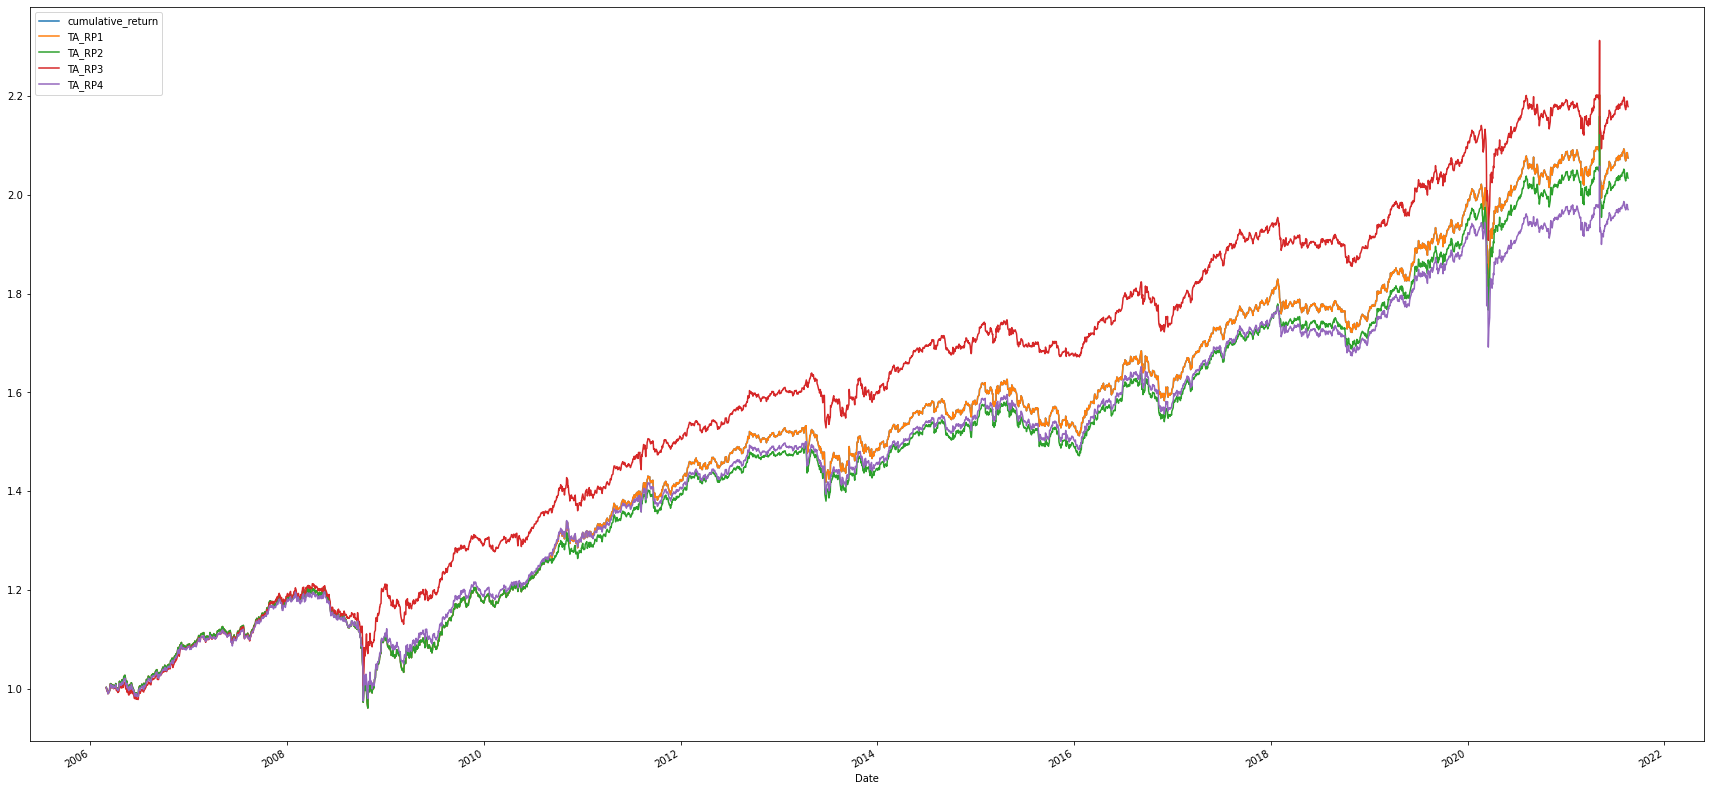

In [40]:
df.plot(figsize=(30,15))

<AxesSubplot:xlabel='Date'>

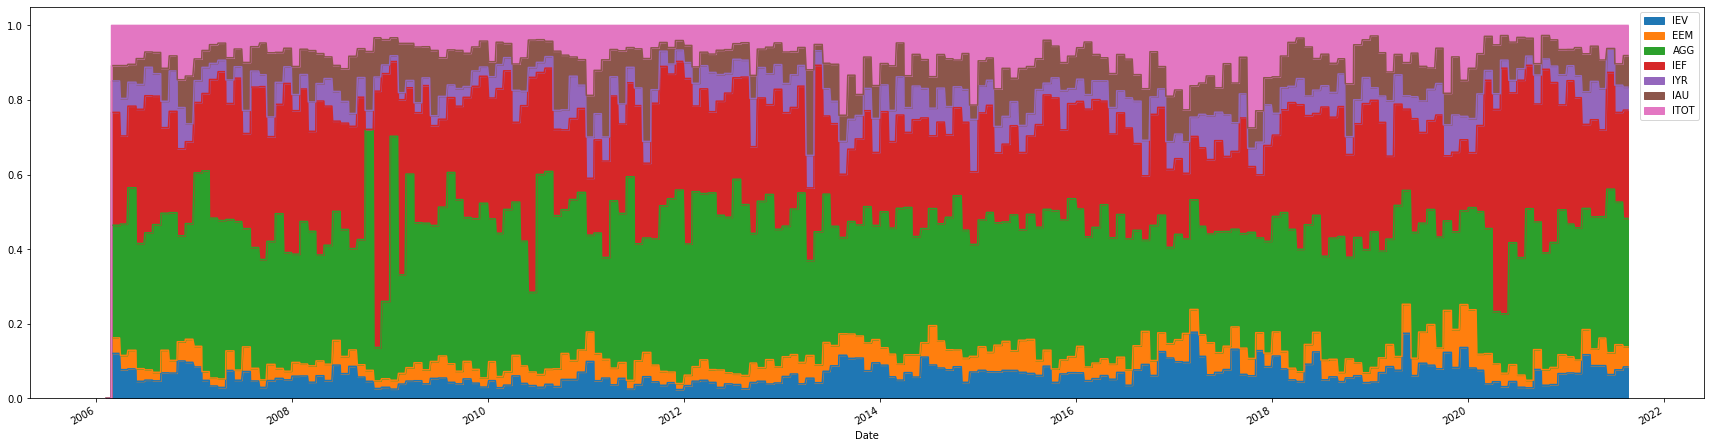

In [9]:
rp_w.plot.area(figsize=(30,8))

<AxesSubplot:xlabel='Date'>

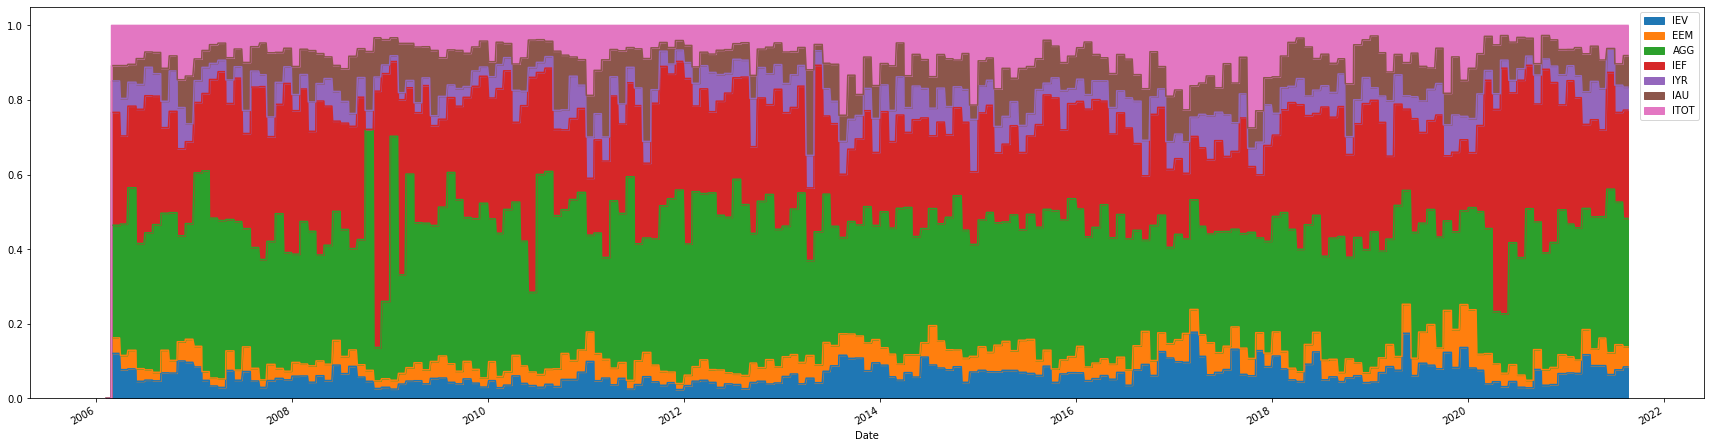

In [10]:
ta_w1.plot.area(figsize=(30,8))

<AxesSubplot:xlabel='Date'>

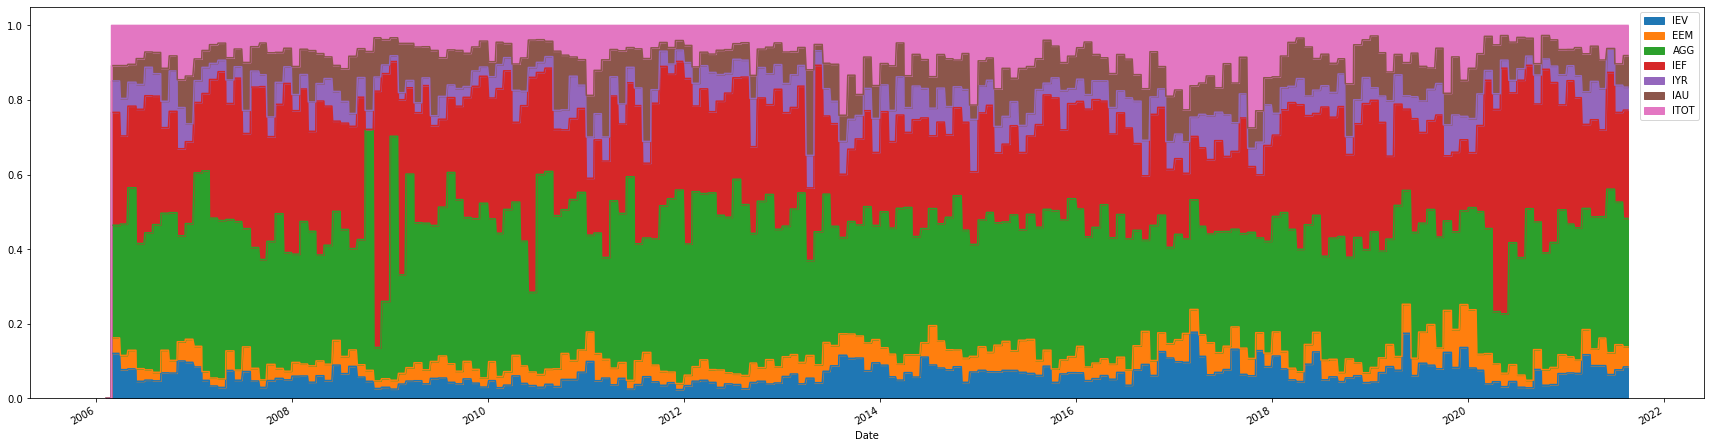

In [11]:
ta_w2.where(ta_w2>0,0).plot.area(figsize=(30,8))

<AxesSubplot:xlabel='Date'>

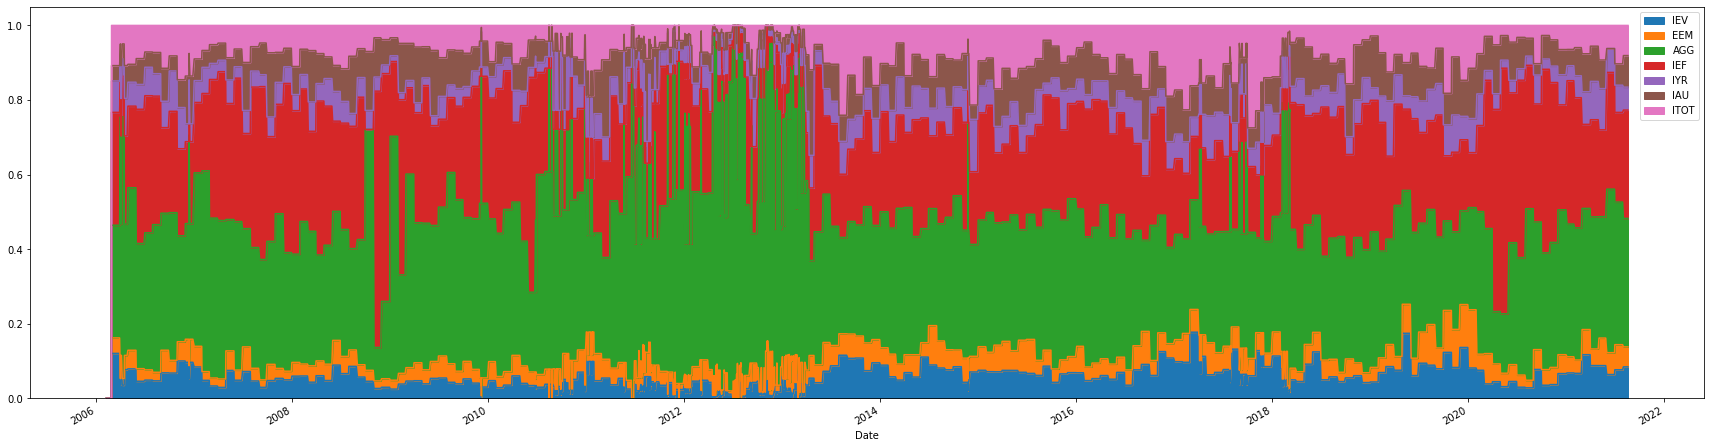

In [12]:
ta_w3.where(ta_w3>0,0).plot.area(figsize=(30,8))

<AxesSubplot:xlabel='Date'>

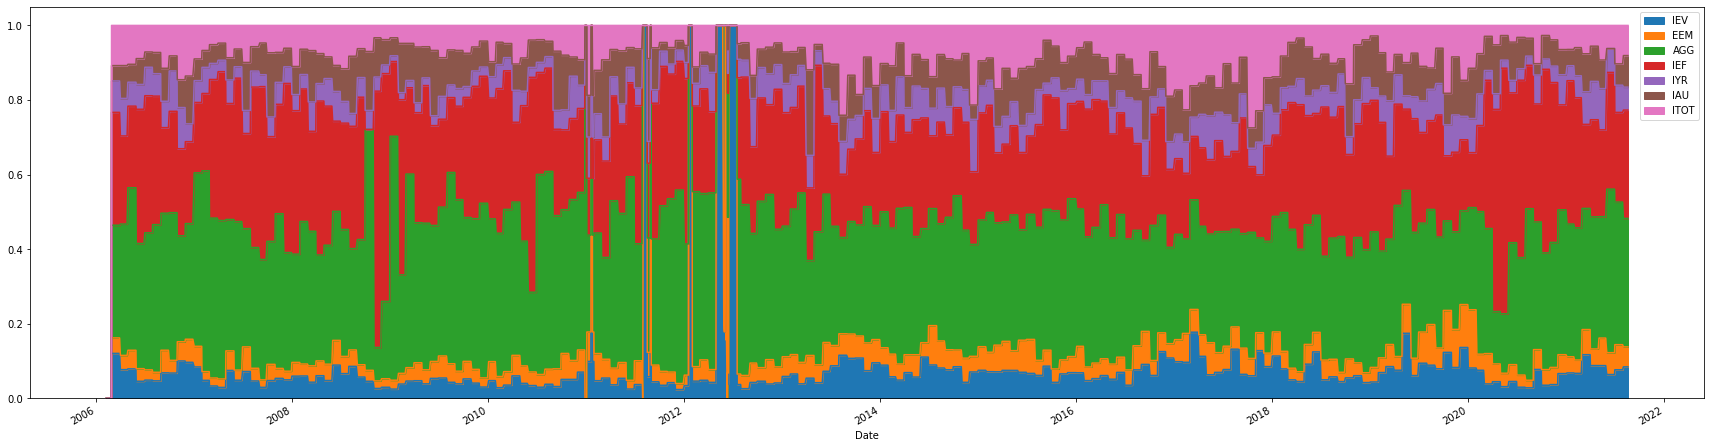

In [13]:
ta_w4.where(ta_w4>0,0).plot.area(figsize=(30,8))

In [36]:
rp = RiskParity(prices)
rp.run()
rp.performance()
rp_w = rp.allocation 
df = rp.equity_curve

# replace existing weights with TA weights then run the strategy
ta_w1 = tactical_allocation(rp_w, data1, threshold=0.05 ,error_adjust=False)
ta_w2 = tactical_allocation(rp_w, data2, threshold=0.05 ,error_adjust=False)
ta_w3 = tactical_allocation(rp_w, data3, threshold=0.05 ,error_adjust=False)
ta_w4 = tactical_allocation(rp_w, data4, threshold=0.05 ,error_adjust=True)
ta_w5 = tactical_allocation(rp_w, data5, threshold=0.05 ,error_adjust=False)


# # get investment results using weights without error correction 
rp.allocation = ta_w1
rp.performance()
df['TA_RP1'] = rp.equity_curve

rp.allocation = ta_w2
rp.performance()
df['TA_RP2'] = rp.equity_curve

rp.allocation = ta_w3
rp.performance()
df['TA_RP3'] = rp.equity_curve


rp.allocation = ta_w4
rp.performance()
df['TA_RP4'] = rp.equity_curve


rp.allocation = ta_w5
rp.performance()
df['TA_RP5'] = rp.equity_curve

ZeroDivisionError: float division by zero

<AxesSubplot:xlabel='Date'>

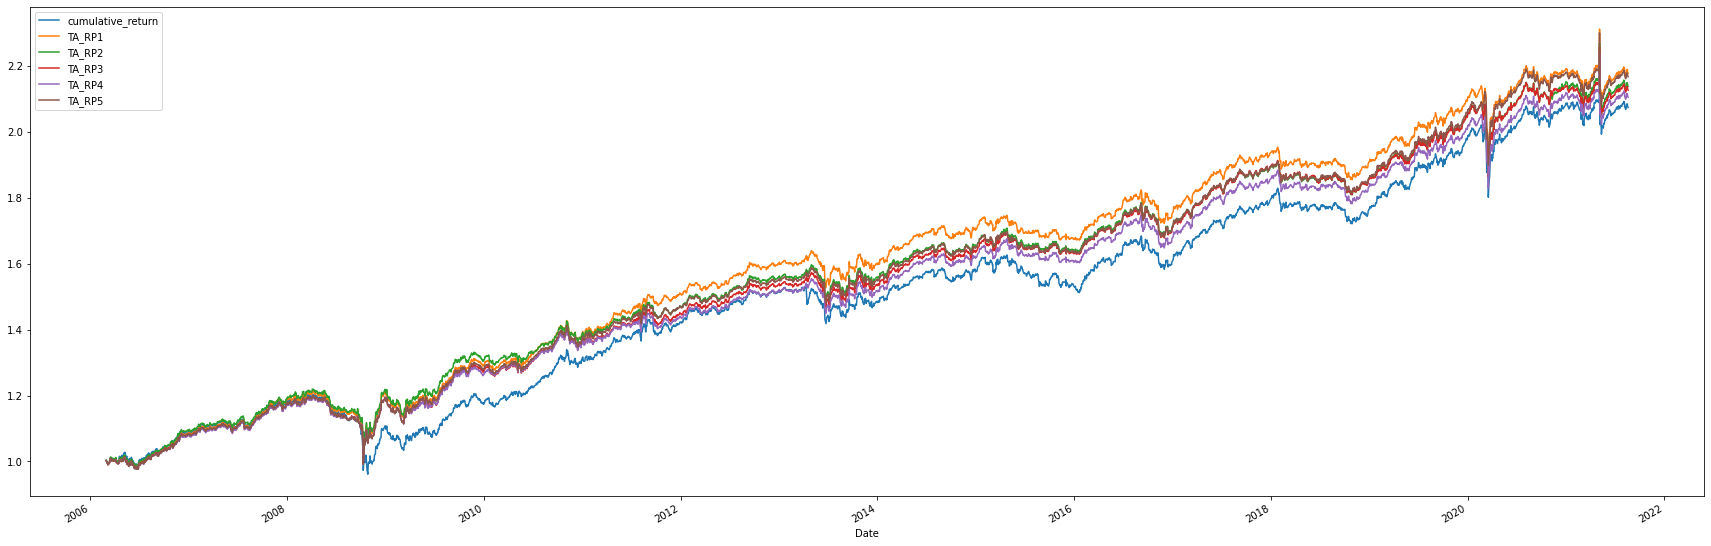

In [ ]:
df.plot(figsize=(30,10))

In [28]:
rp_w

,IEV,EEM,AGG,IEF,IYR,IAU,ITOT
Date,,,,,,,
2006-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-08-13,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797
2021-08-16,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797
2021-08-17,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797


In [29]:
ta_w5

,IEV,EEM,AGG,IEF,IYR,IAU,ITOT
Date,,,,,,,
2006-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-08-13,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797
2021-08-16,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797
2021-08-17,0.084646,0.053617,0.344388,0.290418,0.06152,0.084613,0.080797


In [32]:
data1.iloc[7:14]

,AGG_exp_return,EEM_exp_return,IAU_exp_return,IEF_exp_return,IEV_exp_return,ITOT_exp_return,IYR_exp_return,AGG_uncertainty,EEM_uncertainty,IAU_uncertainty,...,IEV_uncertainty,ITOT_uncertainty,IYR_uncertainty,AGG_mae,EEM_mae,IAU_mae,IEF_mae,IEV_mae,ITOT_mae,IYR_mae
Date,,,,,,,,,,,,,,,,,,,,,
2006-02-21,0.033162,0.060287,0.096049,0.033074,0.021480,0.022969,0.026754,0.041921,0.039113,0.032874,...,0.040939,0.056112,0.055097,0.037249,0.063819,0.042596,0.046324,0.094591,0.046431,0.076904
2006-02-22,0.032776,0.061862,0.095867,0.037456,0.020756,0.026241,0.025911,0.043613,0.038002,0.034106,...,0.040444,0.054344,0.054423,0.037412,0.065668,0.040185,0.046663,0.092985,0.046304,0.074742
2006-02-23,0.034063,0.060679,0.097463,0.035943,0.023128,0.028015,0.030679,0.042285,0.039071,0.033833,...,0.043821,0.058522,0.054154,0.037345,0.066550,0.038810,0.046663,0.092611,0.046350,0.072941
2006-02-24,0.030252,0.061464,0.096111,0.035688,0.022474,0.029683,0.028952,0.046522,0.040367,0.035793,...,0.046140,0.060925,0.054449,0.037582,0.067031,0.037464,0.047233,0.092981,0.046679,0.073287
2006-02-27,0.031665,0.060682,0.094329,0.035684,0.020531,0.027883,0.024984,0.048046,0.040001,0.038588,...,0.046925,0.064343,0.054895,0.037764,0.068803,0.038113,0.047718,0.093306,0.047418,0.074067
2006-02-28,0.028583,0.067180,0.094749,0.037758,0.030804,0.032839,0.039243,0.047204,0.042558,0.037899,...,0.046219,0.061615,0.055380,0.037971,0.066858,0.037516,0.048114,0.093717,0.047519,0.073476
2006-03-01,0.031697,0.058004,0.092939,0.034427,0.019674,0.026824,0.029777,0.046369,0.039998,0.036359,...,0.044207,0.059643,0.055729,0.038138,0.066473,0.038394,0.048149,0.094118,0.047510,0.074060
